In [40]:
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import pickle

model = KeyedVectors.load('./model/word2vec_ramen_model_v2.model')

max_vocab = 30000 
vocab = model.wv.index_to_key[:max_vocab]
vectors = [model.wv[word] for word in vocab]

n_clusters = 6 #クラスター数
kmeans_model = KMeans(n_clusters=n_clusters, verbose=0, random_state=42)
kmeans_model.fit(vectors)

cluster_labels = kmeans_model.labels_
cluster_to_words = defaultdict(list)

for cluster_id, word in zip(cluster_labels, vocab):
    cluster_to_words[cluster_id].append(word)

In [24]:
for words in cluster_to_words.values():
    print(words[:20])

['スープ', 'よう', '醤油', '美味しい', 'これ', '感じ', '良い', '煮干し', '旨味', '濃厚', 'いい', '出汁', '香り', '味わい', 'つけ', '風味', '良く', '魚介', 'なく', 'バランス']
['ラーメン', 'こと', 'そう', 'もの', 'ない', 'それ', '好き', 'ところ', 'ここ', '一杯', '美味しかっ', '美味しく', '高い', 'みたい', 'ため', '多い', '自分', '以上', '通り', 'なし']
['チャーシュー', 'メンマ', 'トッピング', 'ワンタン', 'ネギ', '食感', '海苔', '具材', '調理', 'シンプル', '味付け', '相性', '0種類', 'タレ', '低温', '柔らかく', '柔らか', '玉子', 'もやし', 'ロース']
['0円', 'そば', '注文', 'つけ麺', '特製', '中華そば', 'メニュー', 'らーめん', '今回', '提供', '普通', 'ご飯', '限定', '味噌', '醤油ラーメン', '塩ラーメン', '¥0', '0g', 'オーダー', '本日']
['0分', '0時', '店内', 'カウンター', '食券', '到着', '待ち', '行列', '購入', '券売機', '入店', '時間', '店主', '開店', '店員', '着席', '雰囲気', '丁寧', '案内', 'お客さん']
['さん', '訪問', 'こちら', '人気', '平日', 'ごちそうさま', 'ラーメン屋', '今日', '徒歩', '食べログ', '名店', '近く', 'オープン', '場所', '百名', 'ランチ', '営業', '評価', '東京', '仕事']


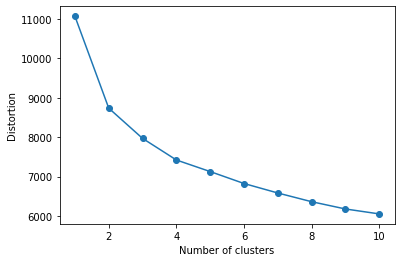

In [29]:
'''
# エルボー図
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(vectors)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
'''

In [51]:
df_dict = pd.DataFrame.from_dict(cluster_to_words, orient="index").T
df_dict.head(20)
'''
3と2と1が使えそう
'''

,3,0,2,1,5,4
0,スープ,ラーメン,チャーシュー,0円,0分,さん
1,よう,こと,メンマ,そば,0時,訪問
2,醤油,そう,トッピング,注文,店内,こちら
3,美味しい,もの,ワンタン,つけ麺,カウンター,人気
4,これ,ない,ネギ,特製,食券,平日
5,感じ,それ,食感,中華そば,到着,ごちそうさま
6,良い,好き,海苔,メニュー,待ち,ラーメン屋
7,煮干し,ところ,具材,らーめん,行列,今日
8,旨味,ここ,調理,今回,購入,徒歩
9,濃厚,一杯,シンプル,提供,券売機,食べログ


In [47]:
# 参考 https://qiita.com/tatsuya-miyamoto/items/f1539d86ad4980624111

from gensim import corpora
from gensim import models

ramen_word = cluster_to_words[3]
ramen_word.extend(cluster_to_words[2])
ramen_word.extend(cluster_to_words[1])

cluster_to_words.keys()



dict_keys([3, 0, 2, 1, 5, 4])

In [48]:
# 作成したラーメンワードと元の口コミコーパスを組み合わせTF-IDF

f = open('./data/200_ramen_corpus.txt','r',encoding="utf-8")
trainings = []

for data in f:
    word = data.replace("'",'').replace('[','').replace(']','').replace(' ','').replace('\n','').split(",")
    trainings.append([i for i in word if i in ramen_word])
"""
trainings:コーパスからラーメンワードを抽出したやつ（店×ワードリストの二次元配列）
"""
# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(trainings)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow, trainings))

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]


In [52]:

# id->単語へ変換
texts_tfidf = [] # id -> 単語表示に変えた文書ごとのTF-IDF
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append([dictionary[word[0]],word[1]])
    texts_tfidf.append(text_tfidf)


texts_tfidf_sorted_top20 = [] 

#TF-IDF値を高い順に並び替え上位単語20個に絞る。
for i in range(len(texts_tfidf)):
    soted = sorted(texts_tfidf[i], key=itemgetter(1),reverse=True)
    soted_top20 = soted[:20]
    word_list = []
    for k in range(len(soted_top20)):
        word = soted_top20[k][0]
        word_list.append(word)
    texts_tfidf_sorted_top20.append(word_list)
# 結果をデータフレームに追加


In [54]:
df = pd.read_csv('./data/200_ramen_review.csv')
df2 = pd.read_csv('./data/200_ramen_store.csv')
df = pd.merge(df, df2, on="ID")
df_ramen = df.groupby(['name', 'score', 'review_count'])['review'].apply(
    list).apply(' '.join).reset_index().sort_values('score', ascending=False)


df_ramen['texts_tfidf_sorted_top20'] = texts_tfidf_sorted_top20
df_ramen['id'] = ['ID-' + str(i + 1).zfill(6) for i in range(len(df_ramen.index))]
df_ramen_texts_tfidf_sorted_top20 = df_ramen.iloc[:,[5,0,1,2,4]].reset_index(drop=True)
df_ramen_texts_tfidf_sorted_top20


,id,name,score,review_count,texts_tfidf_sorted_top20
0,ID-000001,らぁ麺や 嶋,3.99,249,"[ワンタン, 炭火, 海老, 昆布, 特製, だれ, 火炙り, 焼き豚, 藻塩, つけ麺, ..."
1,ID-000002,Homemade Ramen 麦苗,3.98,758,"[いりこ, 黒毛和牛, 火山, spf豚, spf, ワンタン, 手入れ, 鰹節, チャー,..."
2,ID-000003,手打式超多加水麺 ののくら,3.96,532,"[ワンタン, 中華そば, 特製, 三つ葉, 鶏胸肉, 生醤油, うどん, 塩か, 大葉, 0..."
3,ID-000004,麺尊 RAGE,3.94,784,"[軍鶏, 替え玉, そば, まぜそば, 卵黄, 醤油漬け, 素地, 特製, レモン, 浸透,..."
4,ID-000005,宍道湖しじみ中華蕎麦 琥珀,3.94,346,"[しじみ, 中華蕎麦, シジミ, ワンタン, 琥珀, バラ, 地鶏, コハク酸, 菅野, 特..."
...,...,...,...,...,...
195,ID-000196,馳走麺 狸穴,3.72,743,"[つけ麺, ナルト, つけ, 全粒粉, 三つ葉, 魚介, 豚骨魚介, 柚子, 根菜, 煮干,..."
196,ID-000197,中華そば 青葉 中野本店,3.72,727,"[0%, 中華そば, ダブル, 豚骨魚介, 柚子, 唐辛子, 特製, つけめん, つけ麺, ..."
197,ID-000198,ラーメン二郎 目黒店,3.72,575,"[ヤサイ, コール, ニンニク, 乳化, 野菜, アブラ, ゴワゴワ, 安い, マシ, 少な..."
198,ID-000199,煮干中華そば鈴蘭,3.72,555,"[煮干し, 煮干, ニボニボ, 中華そば, 炭火, みじん, 玉ねぎ, 白湯スープ, おつま..."


In [57]:
pickle.dump(df_ramen_texts_tfidf_sorted_top20, open('./work/df_ramen_texts_tfidf_sorted_top20', 'wb'))

In [60]:
f = open('./work/df_ramen_texts_tfidf_sorted_top20','rb')
store_df = pickle.load(f)
store_df

,id,name,score,review_count,texts_tfidf_sorted_top20
0,ID-000001,らぁ麺や 嶋,3.99,249,"[ワンタン, 炭火, 海老, 昆布, 特製, だれ, 火炙り, 焼き豚, 藻塩, つけ麺, ..."
1,ID-000002,Homemade Ramen 麦苗,3.98,758,"[いりこ, 黒毛和牛, 火山, spf豚, spf, ワンタン, 手入れ, 鰹節, チャー,..."
2,ID-000003,手打式超多加水麺 ののくら,3.96,532,"[ワンタン, 中華そば, 特製, 三つ葉, 鶏胸肉, 生醤油, うどん, 塩か, 大葉, 0..."
3,ID-000004,麺尊 RAGE,3.94,784,"[軍鶏, 替え玉, そば, まぜそば, 卵黄, 醤油漬け, 素地, 特製, レモン, 浸透,..."
4,ID-000005,宍道湖しじみ中華蕎麦 琥珀,3.94,346,"[しじみ, 中華蕎麦, シジミ, ワンタン, 琥珀, バラ, 地鶏, コハク酸, 菅野, 特..."
...,...,...,...,...,...
195,ID-000196,馳走麺 狸穴,3.72,743,"[つけ麺, ナルト, つけ, 全粒粉, 三つ葉, 魚介, 豚骨魚介, 柚子, 根菜, 煮干,..."
196,ID-000197,中華そば 青葉 中野本店,3.72,727,"[0%, 中華そば, ダブル, 豚骨魚介, 柚子, 唐辛子, 特製, つけめん, つけ麺, ..."
197,ID-000198,ラーメン二郎 目黒店,3.72,575,"[ヤサイ, コール, ニンニク, 乳化, 野菜, アブラ, ゴワゴワ, 安い, マシ, 少な..."
198,ID-000199,煮干中華そば鈴蘭,3.72,555,"[煮干し, 煮干, ニボニボ, 中華そば, 炭火, みじん, 玉ねぎ, 白湯スープ, おつま..."
